We take the same introduction to correctly organize our data.

# Extraction

In [ ]:
!pip install -U -q PyDrive
!pip install -U scikit-learn
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import seaborn as sn

link="https://drive.google.com/open?id=1ekH_MmN_ofsmz6bR3xHrRnmDfXSDCWQK"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')
hSSW_wdeltabike= pd.read_csv('myfile.csv')
print('hSSW_wdeltabike imported')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22)
hSSW_wdeltabike imported


In [ ]:
hSSW_wdeltabike

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,634687,70,6,13,False,True,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,19,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634688,634688,71,5,14,False,True,Powell at Post (Union Square),37.788446,-122.408499,19,San Francisco,8/23/2013,-2.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634689,634689,72,14,9,False,True,Civic Center BART (7th at Market),37.781039,-122.411748,23,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634690,634690,73,10,4,False,True,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,8/21/2013,-3.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1


In [ ]:
hSSW_wdeltabike['city'].unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

# Coherence Check and Cleaning

<BarContainer object of 14 artists>

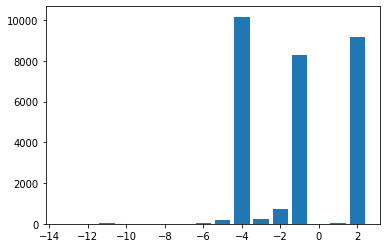

In [ ]:
hSSW_wdeltabike['check']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']-hSSW_wdeltabike['dock_count']
unique,count=np.unique(hSSW_wdeltabike['check'],return_counts=True)
plt.bar(np.delete(unique,-3),np.delete(count,-3)) #delete count of value 0

<BarContainer object of 69 artists>

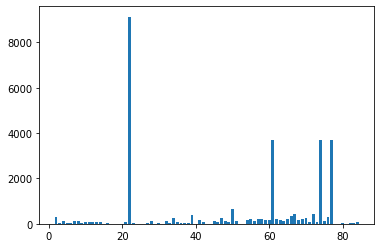

In [ ]:
unique_id,count_id=np.unique(hSSW_wdeltabike[hSSW_wdeltabike['check']!=0]['station_id'],return_counts=True)
plt.bar(unique_id,count_id)

In [ ]:
unique_id,count_id

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 21, 22, 23,
        24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
        45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83,
        84], dtype=int64),
 array([ 298,   56,  124,   52,   38,  105,  110,   33,   78,   78,   83,
          98,   84,   50,   60, 9130,   22,    2,    4,   23,  122,    2,
          22,    5,  112,   45,  257,   70,   15,   30,   26,  382,  162,
         100,  133,   63,  261,  104,   79,  667,  110,  147,  227,  107,
         200,  212,  174,  161, 3675,  198,  170,  133,  207,  341,  434,
         172,  223,  246,   82,  434,   66, 3715,  118,  317, 3714,   19,
          56,   32,   66]))

In [ ]:
count_id[np.argsort(count_id)[-4:]],unique_id[np.argsort(count_id)[-4:]]

(array([3675, 3714, 3715, 9130]), array([61, 77, 74, 22], dtype=int64))

In [ ]:
np.unique(hSSW_wdeltabike[hSSW_wdeltabike['station_id']==22]['check'],return_counts=True)

(array([-1,  0,  1,  2], dtype=int64), array([   3,  250,   39, 9088]))

We can certainly deduce an error in the dock count. In addition, the number of bikes and docks available is varaible, contrary to the dock_count, which is fixed. If some docks are under repair, we will see them in the availability variable, but not in the dock_count.

In [ ]:
np.unique(hSSW_wdeltabike['dock_count'],return_counts=True)

(array([11, 15, 19, 23, 25, 27], dtype=int64),
 array([ 34598, 300137, 168663,  84397,   9380,  37517]))

In [ ]:
hSSW_wdeltabike['dock_total']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']

# Categorical Label Implementation

In [ ]:
hSSW_wdeltabike['Category']=1

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['bikes_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=0
hSSW_wdeltabike.loc[(hSSW_wdeltabike['docks_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=2

# Features Selection and Modification

### City

In [ ]:
City=pd.get_dummies(hSSW_wdeltabike['city'])
City.head()

,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### Weather

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

Goal: Simplify the Weather Description to a more General weather:
- Sunny: Sky is clear
- Cloudy: Broken clouds, Few clouds, Scattered clouds, Overcast clouds
- Foggy: Mist, Fog, Haze, 
- Light Rain: light rain, light intensity drizzle, thunderstorm with light rain,light intensity shower rain
- Moderate Rain: moderate rain, drizzle, thunderstorm with rain
- Heavy Rain: heavy intensity rain, heavy intensity drizzle, thunderstorm with heavy rain, very heavy rain
- Proximity to Rain: thunderstorm, proximity thunderstorm, proximity shower rain, proximity thunderstorm with rain

In [ ]:
hSSW_wdeltabike['Weather_Simplified']=hSSW_wdeltabike['Weather_Description']

In [ ]:
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='sky is clear','Weather_Simplified']='Sunny'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='broken clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='few clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='scattered clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='overcast clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='mist','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='fog','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='haze','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity drizzle','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity shower rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='moderate rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='drizzle','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity drizzle','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='very heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity shower rain','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm with rain','Weather_Simplified']='Proximity to Rain'

In [ ]:
hSSW_wdeltabike['Rain']=1
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Sunny','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Cloudy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Foggy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Proximity to Rain','Rain']=0

Weather Description from 23 to 7 categories, and an additional dummy Rain column.

In [ ]:
Weather_Simplified=pd.get_dummies(hSSW_wdeltabike['Weather_Simplified'])
Weather_Simplified.head()

,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


### Wind Direction

In [ ]:
hSSW_wdeltabike['Wind_Orientation']='North'

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>45) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=135),'Wind_Orientation']='East'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>135) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=225),'Wind_Orientation']='South'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>225) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=315),'Wind_Orientation']='West'

In [ ]:
Wind_Orientation=pd.get_dummies(hSSW_wdeltabike['Wind_Orientation'])
Wind_Orientation.head()

,East,North,South,West
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


### Time

In [ ]:
hSSW_wdeltabike['Hour']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.hour
hSSW_wdeltabike['Month']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.month

In [ ]:
hSSW_wdeltabike.head()

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed,check,dock_total,Category,Weather_Simplified,Rain,Wind_Orientation,Hour,Month
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,27,0,Cloudy,0,South,13,8
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,11,0,Cloudy,0,South,13,8
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,19,1,Cloudy,0,South,13,8
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8


### Merge

In [ ]:
ML_data=hSSW_wdeltabike[['Category','station_id','bikes_available','docks_available','Holiday','Weekend','Humidity','Pressure','Temperature',\
                         'Wind_Direction','Wind_Speed','Rain','Hour','Month']]

In [ ]:
ML_data=pd.merge(ML_data,City,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Weather_Simplified,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Wind_Orientation,left_index=True,right_index=True)

In [ ]:
ML_data=ML_data.astype({'Holiday': int, 'Weekend': int})

In [ ]:
ML_data

,Category,station_id,bikes_available,docks_available,Holiday,Weekend,Humidity,Pressure,Temperature,Wind_Direction,Wind_Speed,Rain,Hour,Month,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny,East,North,South,West
0,0,2,2,25,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,1,3,9,6,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,4,0,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
3,1,5,9,10,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
4,1,6,4,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,1,70,6,13,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634688,1,71,5,14,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634689,1,72,14,9,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634690,1,73,10,4,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


# Machine Learning Models

### K-Neighbors

First model with all features and non-standardized data, in order to have a first result without any modification or Feature Engineering.

In [ ]:
data1=ML_data.copy()

In [ ]:
data1.drop(columns=['bikes_available','docks_available','Wind_Direction'],inplace=True)

In [ ]:
X1_rest,X1_test,Y1_rest,Y1_test=train_test_split(data1.drop(columns=['Category']),data1['Category'],train_size=0.8,shuffle=True)
X1_train,X1_validation,Y1_train,Y1_validation=train_test_split(X1_rest,Y1_rest,train_size=0.8,shuffle=True)

In [ ]:
model1=KNeighborsClassifier()
model1.fit(X1_train,Y1_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
Y1_train_pred=model1.predict(X1_train)
np.average(Y1_train_pred==Y1_train)

0.9670114868956824

In [ ]:
Y1_validation_pred=model1.predict(X1_validation)
np.average(Y1_validation_pred==Y1_validation)

0.9644218176088861

We get pretty good accuracy, let's check with the confusion matrix.

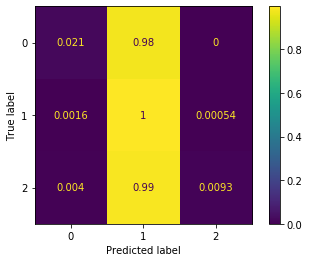

In [ ]:
CM1_validation_true=plot_confusion_matrix(model1,X1_validation,Y1_validation,normalize='true')

In fact, we have a bad prediction of minority classes. We only detect 2% of empty stations, and 1% of full stations.

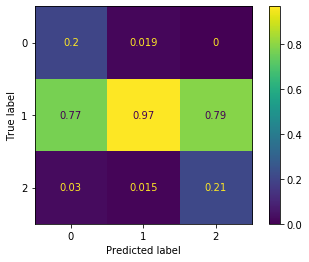

In [ ]:
CM1_validation_pred=plot_confusion_matrix(model1,X1_validation,Y1_validation,normalize='pred')

In addition, on this model, 80% of our 0 predictions are false predictions, and 79% of our 2 predictions are false predictions.

We test a Second Model without Weather features

In [ ]:
data2=ML_data.copy()

In [ ]:
data2.drop(columns=['bikes_available','docks_available','Wind_Direction','Humidity','Pressure','Temperature','Wind_Speed','Rain',\
                    'Sunny','Cloudy','Foggy','Light Rain','Moderate Rain','Heavy Rain','Proximity to Rain','East','North','South','West'],inplace=True)

In [ ]:
X2_rest,X2_test,Y2_rest,Y2_test=train_test_split(data2.drop(columns=['Category']),data2['Category'],train_size=0.8,shuffle=True)
X2_train,X2_validation,Y2_train,Y2_validation=train_test_split(X2_rest,Y2_rest,train_size=0.8,shuffle=True)

In [ ]:
model2=KNeighborsClassifier()
model2.fit(X2_train,Y2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
Y2_train_pred=model2.predict(X2_train)
np.average(Y2_train_pred==Y2_train)

0.9646924436610357

In [ ]:
Y2_validation_pred=model2.predict(X2_validation)
np.average(Y2_validation_pred==Y2_validation)

0.9640968577365068

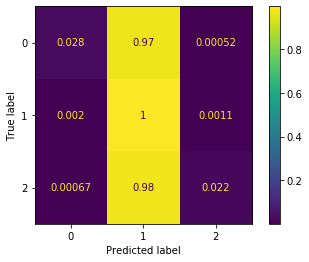

In [ ]:
CM2_validation_true=plot_confusion_matrix(model2,X2_validation,Y2_validation,normalize='true')

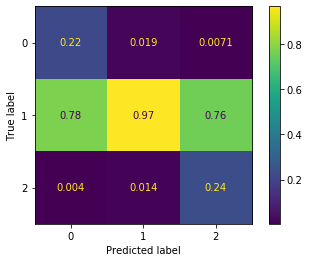

In [ ]:
CM2_validation_pred=plot_confusion_matrix(model2,X2_validation,Y2_validation,normalize='pred')

We get the same results...

We test a third Model without City, and Time features

In [ ]:
data3=ML_data.copy()

In [ ]:
data3.drop(columns=['Holiday','Weekend','Hour','Month','Mountain View','Palo Alto','Redwood City','San Francisco','San Jose'],inplace=True)

In [ ]:
X3_rest,X3_test,Y3_rest,Y3_test=train_test_split(data3.drop(columns=['Category']),data3['Category'],train_size=0.8,shuffle=True)
X3_train,X3_validation,Y3_train,Y3_validation=train_test_split(X3_rest,Y3_rest,train_size=0.8,shuffle=True)

In [ ]:
model3=KNeighborsClassifier()
model3.fit(X3_train,Y3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
Y3_train_pred=model3.predict(X3_train)
np.average(Y3_train_pred==Y3_train)

0.9808765097168404

In [ ]:
Y3_validation_pred=model3.predict(X3_validation)
np.average(Y3_validation_pred==Y3_validation)

0.9734222213469095

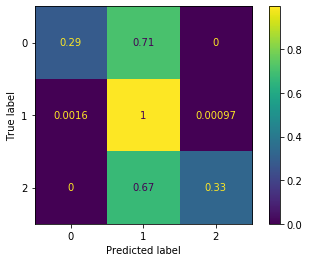

In [ ]:
CM3_validation_true=plot_confusion_matrix(model3,X3_validation,Y3_validation,normalize='true')

We get much better results. Now we detect 29% of 0 situations and 33% of 2 situations.

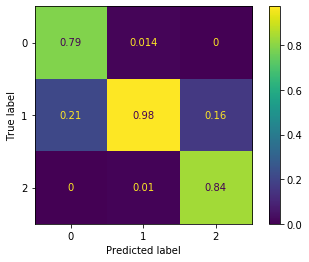

In [ ]:
CM3_validation_pred=plot_confusion_matrix(model3,X3_validation,Y3_validation,normalize='pred')

In addition, 79% of our 0 predictions are accurate, and up to 84% for full stations predictions.

We decided to add to this model Time informations, Hours and Months, to see if we get an improvement.

In [ ]:
data3_bis=ML_data.copy()

In [ ]:
data3_bis.drop(columns=['Holiday','Weekend','Mountain View','Palo Alto','Redwood City','San Francisco','San Jose'],inplace=True)

In [ ]:
X3_bis_rest,X3_bis_test,Y3_bis_rest,Y3_bis_test=train_test_split(data3_bis.drop(columns=['Category']),data3_bis['Category'],train_size=0.8,shuffle=True)
X3_bis_train,X3_bis_validation,Y3_bis_train,Y3_bis_validation=train_test_split(X3_bis_rest,Y3_bis_rest,train_size=0.8,shuffle=True)

In [ ]:
model3_bis=KNeighborsClassifier()
model3_bis.fit(X3_bis_train,Y3_bis_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
Y3_bis_train_pred=model3_bis.predict(X3_bis_train)
np.average(Y3_bis_train_pred==Y3_bis_train)

0.9789735156400018

In [ ]:
Y3_bis_validation_pred=model3_bis.predict(X3_bis_validation)
np.average(Y3_bis_validation_pred==Y3_bis_validation)

0.9700643026656557

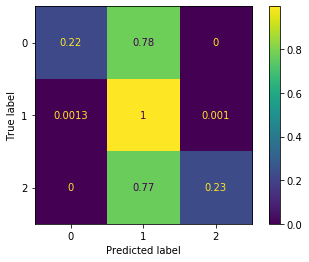

In [ ]:
CM3_bis_validation_true=plot_confusion_matrix(model3_bis,X3_bis_validation,Y3_bis_validation,normalize='true')

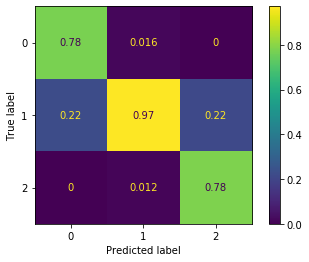

In [ ]:
CM3_bis_validation_pred=plot_confusion_matrix(model3_bis,X3_bis_validation,Y3_bis_validation,normalize='pred')

We don't get better result. Thus the best model is the third one.

Now, we can optimize the K Hyper-Parameter by Cross-Validation.

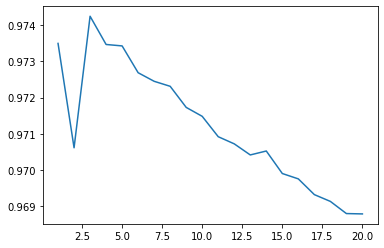

In [ ]:
K=np.arange(1,21)
accuracy_list=[]
for k in K:
  model3_cv=KNeighborsClassifier(k)
  model3_cv.fit(X3_train,Y3_train)
  Y3_validation_pred=model3_cv.predict(X3_validation)
  accuracy_list.append(np.average(Y3_validation_pred==Y3_validation))
plt.plot(K,accuracy_list)

We deduce that the best K parameter is K=3.

In [ ]:
best_model3=KNeighborsClassifier(3)
best_model3.fit(X3_train,Y3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y3_train_pred=best_model3.predict(X3_train)
np.average(Y3_train_pred==Y3_train)

0.9864008547471456

In [ ]:
Y3_validation_pred=best_model3.predict(X3_validation)
np.average(Y3_validation_pred==Y3_validation)

0.9742395446622879

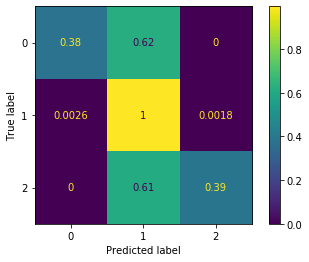

In [ ]:
CM3_best_validation_true=plot_confusion_matrix(best_model3,X3_validation,Y3_validation,normalize='true')

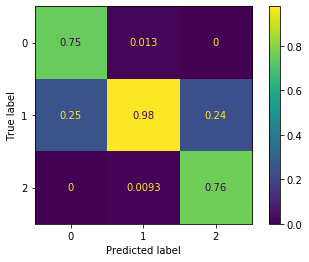

In [ ]:
CM3_best_validation_pred=plot_confusion_matrix(best_model3,X3_validation,Y3_validation,normalize='pred')

In [ ]:
Y3_test_pred=best_model3.predict(X3_test)
np.average(Y3_test_pred==Y3_test)

0.9747358967693144

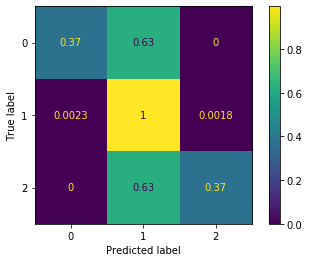

In [ ]:
CM3_best_test_true=plot_confusion_matrix(best_model3,X3_test,Y3_test,normalize='true')

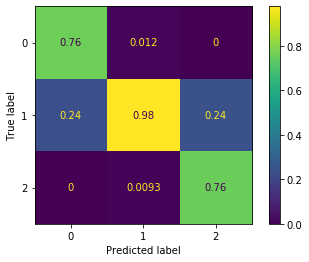

In [ ]:
CM3_best_test_pred=plot_confusion_matrix(best_model3,X3_test,Y3_test,normalize='pred')

Hence, we boost our detection accuracy to 37% on empty station, and 37% on full stations.

Moreover, 76% of predictions are accurate, both on empty and full stations.

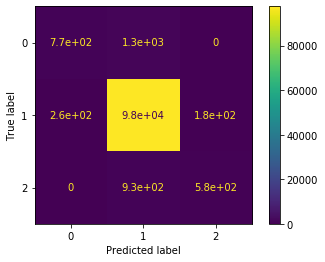

In [ ]:
CM3_best_validation_all=plot_confusion_matrix(best_model3,X3_validation,Y3_validation)

In [ ]:
CM3_best_validation_all.confusion_matrix

array([[  767,  1252,     0],
       [  257, 97585,   181],
       [    0,   926,   583]])

We tried to implement a Feature Forward Selection, but it didn't work well, as we couldn't find a particular better Feature.

In [ ]:
data4=ML_data.copy()

In [ ]:
features=['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure',\
       'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour',\
       'Month']

In [ ]:
data4.drop(columns=['bikes_available','docks_available'],inplace=True)

In [ ]:
X4_rest,X4_test,Y4_rest,Y4_train=train_test_split(data4[features],data4['Category'],train_size=0.8,shuffle=True)
X4_train,X4_validation,Y4_train,Y4_validation=train_test_split(X4_rest,Y4_rest,train_size=0.8,shuffle=True)

In [ ]:
candidate_variables=np.array(data4.drop(columns=['Category']).columns)
candidate_variables

array(['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure',
       'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour',
       'Month', 'Mountain View', 'Palo Alto', 'Redwood City',
       'San Francisco', 'San Jose', 'Cloudy', 'Foggy', 'Heavy Rain',
       'Light Rain', 'Moderate Rain', 'Proximity to Rain', 'Sunny',
       'East', 'North', 'South', 'West'], dtype=object)

In [ ]:
def forward_selection(features,X_train,Y_train,X_val,Y_val,model):
    remaining_features=features[:]
    features_kept=[]
    best_accuracy=0
    count=0
    while len(remaining_features)>0:
        accuracy_min=0
        feature_candidate=None
        for feature in remaining_features:
            print("REMAINING:", remaining_features)
            print("KEPT: ",features_kept)
            print("TRYING:",feature)
            print("CANDIDATE",feature_candidate)
            features_tried=features_kept+[feature]
            model.fit(X_train[features_tried],Y_train)
            count+=1
            Y_pred=model.predict(X_val[features_tried])
            accuracy=np.average(Y_pred==Y_val)
            print(accuracy,accuracy_min)
            if (accuracy>accuracy_min):
                feature_candidate=feature
                accuracy_min=accuracy
                
        if accuracy_min>best_accuracy: # accept new feature
            features_kept.append(feature_candidate)
            remaining_features.remove(feature_candidate)
            best_accuracy=accuracy_min
        else: # we did not improve on the valuation set, stop searching
            break
    return features_kept,best_accuracy,count

In [ ]:
model4=KNeighborsClassifier(3)

In [ ]:
forward_selection(features,X4_train,Y4_train,X4_validation,Y4_validation,model4)

REMAINING: ['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure', 'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour', 'Month']
KEPT:  []
TRYING: station_id
CANDIDATE None
0.9520438006518892 0
REMAINING: ['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure', 'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour', 'Month']
KEPT:  []
TRYING: Holiday
CANDIDATE station_id
0.9659481442821833 0.9520438006518892
REMAINING: ['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure', 'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour', 'Month']
KEPT:  []
TRYING: Weekend
CANDIDATE Holiday
0.9659481442821833 0.9659481442821833
REMAINING: ['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure', 'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour', 'Month']
KEPT:  []
TRYING: Humidity
CANDIDATE Holiday
0.9659481442821833 0.9659481442821833
REMAINING: ['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure', 'Temperature', 'Wind_Direction', 'Win

(['Holiday'], 0.9659481442821833, 21)

Finally, we only get that the better model is the model using only station_id, or Holiday or Weekend. This Feature Selection is a bit random, because of the huge amount of majority datas.

In [ ]:
data4_bis=ML_data.copy()

In [ ]:
features=['station_id', 'Holiday', 'Weekend', 'Humidity', 'Pressure',\
       'Temperature', 'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour',\
       'Month']

In [ ]:
data4_bis=data4_bis[['Category','station_id']]

In [ ]:
X4_bis_rest,X4_bis_test,Y4_bis_rest,Y4_bis_train=train_test_split(data4_bis['station_id'],data4_bis['Category'],train_size=0.8,shuffle=True)
X4_bis_train,X4_bis_validation,Y4_bis_train,Y4_bis_validation=train_test_split(X4_bis_rest,Y4_bis_rest,train_size=0.8,shuffle=True)

In [ ]:
model4.fit(np.array(X4_bis_train).reshape(-1,1),Y4_bis_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y4_bis_train_pred=model4.predict(np.array(X4_bis_train).reshape(-1,1))
np.average(Y4_bis_train_pred==Y4_bis_train)

0.9654950000246183

In [ ]:
Y4_bis_validation_pred=model4.predict(np.array(X4_bis_validation).reshape(-1,1))
np.average(Y4_bis_validation_pred==Y4_bis_validation)

0.9658693661313035

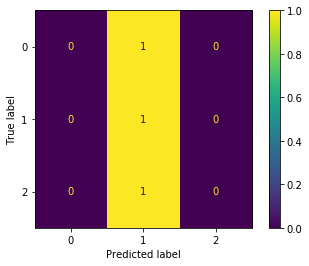

In [ ]:
CM4_bis_validation_true=plot_confusion_matrix(model4,np.array(X4_bis_validation).reshape(-1,1),Y4_bis_validation,normalize='true')

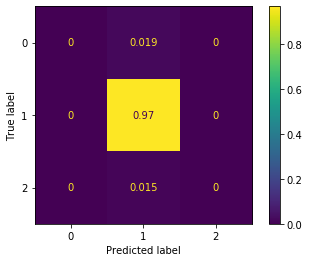

In [ ]:
CM4_bis_validation_pred=plot_confusion_matrix(model4,np.array(X4_bis_validation).reshape(-1,1),Y4_bis_validation,normalize='pred')

But we get poor results, as we do nothing, and we can't predict any problematic situation.

### Random Forest Classifier

We tried another classifier, which is a RandomForestClassifier

In [ ]:
model5=RandomForestClassifier(max_depth=5)

In [ ]:
model5.fit(X3_train,Y3_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model5.feature_importances_

array([7.82323532e-01, 3.26909239e-02, 3.93811206e-02, 7.58326102e-02,
       2.84168059e-02, 1.11075373e-02, 3.50564450e-03, 2.90926261e-03,
       1.69500448e-03, 4.60069300e-04, 1.03626732e-03, 4.74477702e-03,
       1.93975759e-03, 1.86053699e-03, 2.97027044e-03, 2.43412052e-03,
       5.13576786e-03, 1.55599173e-03])

In [ ]:
X3_train.columns

Index(['station_id', 'Humidity', 'Pressure', 'Temperature', 'Wind_Direction',
       'Wind_Speed', 'Rain', 'Cloudy', 'Foggy', 'Heavy Rain', 'Light Rain',
       'Moderate Rain', 'Proximity to Rain', 'Sunny', 'East', 'North', 'South',
       'West'],
      dtype='object')

In [ ]:
Y5_validation_pred=model5.predict(X3_validation)
np.average(Y5_validation_pred==Y3_validation)

0.9653966972260244

In [ ]:
Y5_test_pred=model5.predict(X3_test)
np.average(Y5_test_pred==Y3_test)

0.9661175840364269

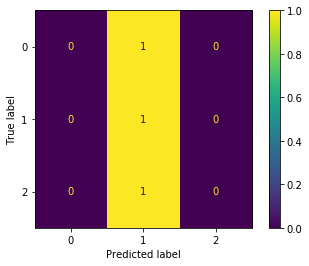

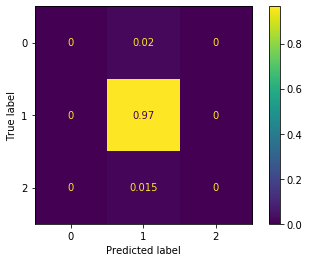

In [ ]:
MT5_validation_true=plot_confusion_matrix(model5,X3_validation,Y3_validation,normalize='true')
MT5_validation_pred=plot_confusion_matrix(model5,X3_validation,Y3_validation,normalize='pred')

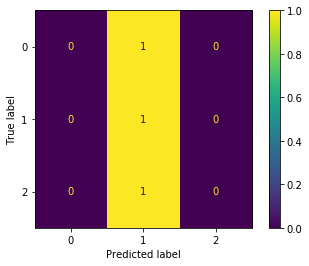

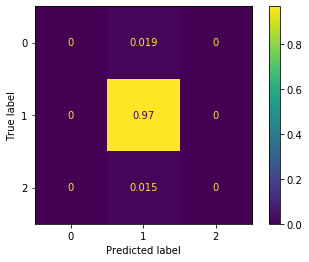

In [ ]:
MT5_test_true=plot_confusion_matrix(model5,X3_test,Y3_test,normalize='true')
MT5_test_pred=plot_confusion_matrix(model5,X3_test,Y3_test,normalize='pred')

We conclude that we get horrible results, because we are overfitting our model.

In [ ]:
model5_bis=RandomForestClassifier(max_depth=5,class_weight={0:40,1:1,2:55})

We decided to weight minority classes in order to increase the accuracy on these minority classes

In [ ]:
model5_bis.fit(X3_train,Y3_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 40, 1: 1, 2: 55}, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
model5_bis.feature_importances_

array([8.08601665e-01, 2.81675121e-02, 2.94807664e-02, 6.01217231e-02,
       3.05549068e-02, 1.17405317e-02, 3.20062972e-03, 1.68237957e-03,
       2.45722623e-03, 4.26589079e-04, 1.63314788e-03, 4.56514308e-03,
       2.06320985e-04, 1.90151636e-03, 2.12576191e-03, 1.61507102e-03,
       7.57835023e-03, 3.94075891e-03])

In [ ]:
Y5_bis_validation_pred=model5.predict(X3_validation)
np.average(Y5_bis_validation_pred==Y3_validation)

0.9653966972260244

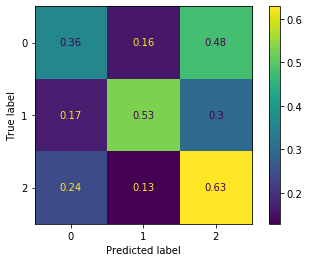

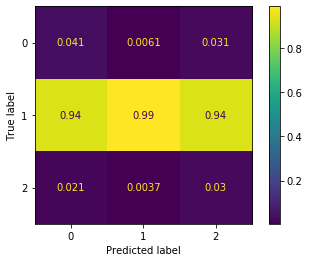

In [ ]:
MT5_bis_validation_true=plot_confusion_matrix(model5_bis,X3_validation,Y3_validation,normalize='true')
MT5_bis_validation_pred=plot_confusion_matrix(model5_bis,X3_validation,Y3_validation,normalize='pred')

In this case, we correctly predict full station, but badly empty stations. In addition, we have a bad prediction of normal stations too.

Finally, we tested a LDA, Linear Discriminant Analysis, as we can approach some parameters by a Gaussian Distribution.

In [ ]:
model6=LDA()

In [ ]:
model6.fit(X3_train,Y3_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
Y6_validation_pred=model6.predict(X3_validation)
np.average(Y6_validation_pred==Y3_validation)

0.9653966972260244

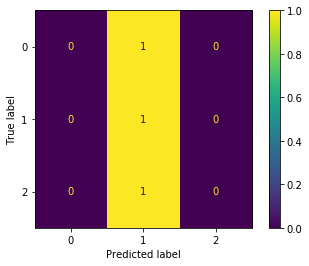

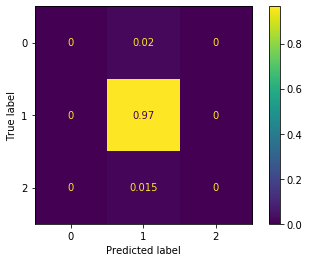

In [ ]:
MT6_validation_true=plot_confusion_matrix(model6,X3_validation,Y3_validation,normalize='true')
MT6_validation_pred=plot_confusion_matrix(model6,X3_validation,Y3_validation,normalize='pred')

Again, we find that this model is not adapted.